In [140]:
# imports libraries
import pickle										# import/export lists
import datetime										# dates
import string										# string parsing
import re 											# regular expression
import pandas as pd									# dataframes
import numpy as np									# numerical computation
import matplotlib.pyplot as plt						# plot graphics
import nltk											# natural language process
from nltk.corpus import stopwords					# stop words
from nltk import word_tokenize						# word tokens
from nltk.util import ngrams						# ngrams
import seaborn as sns								# graphics supplemental

In [2]:
# opens raw data
with open ('../clean_data/df_profile', 'rb') as fp:
    df = pickle.load(fp)
    
# creates subset of data of active users
df_active = df.loc[df.status != 'inactive', ].copy()

# sets current year
cyear = datetime.datetime.now().year

# sets stop word list for text parsing
stop_word_list = stopwords.words('english')

# User Analysis

In this section, we take a sample of ~10,000 users from fanfiction.net and break down some of their characteristics.

## Activity and volume

Let's begin by examining the types of profiles that make up the userbase: readers, authors, or inactive users. Inactive users are accounts that are no longer existing.

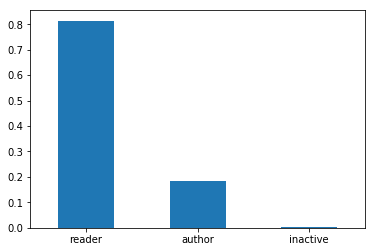

In [3]:
# examines status of users
status = df['status'].value_counts()

# plots chart
(status/np.sum(status)).plot.bar()
plt.xticks(rotation=0)
plt.show()

About ~20% of users on the site are authors! That's much higher than expected. The number of inactive profiles is also notably negligible, meaning that once a profile has been created, it is very unlikely to be ever deleted or pulled off the site. 

How about fast people are joining the site?

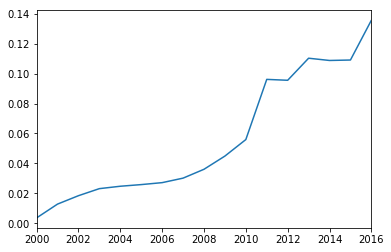

In [4]:
# examines when stories first created
entry = [int(row[2]) for row in df_active['join'] if row != 'NA']
entry = pd.Series(entry).value_counts().sort_index()

# plots chart
(entry/np.sum(entry)).plot()
plt.xlim([np.min(entry.index.values), cyear-1])
plt.show()

Note that sharp increase in 2011! Wonder what could have caused that surge...

## Countries

The site fanfiction.net allows tracking of location for users. Let's examine where these users are from.

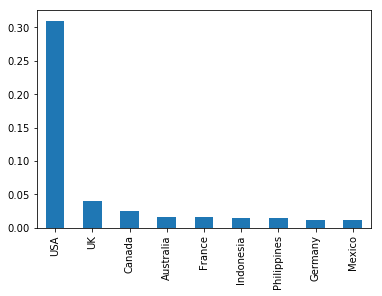

In [5]:
# examines distribution of top 10 countries
country = df['country'].value_counts()
(country[1:10]/np.sum(country)).plot.bar()
plt.xticks(rotation=90)

plt.show()

We looked at the top 10 countries. Over ~30% are from United States!

## Profile descriptions

Users have the option of including a profile description. Let's see what percentage of the active userbase has them. 

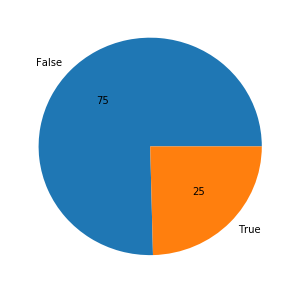

In [103]:
hasprofile = [row != '' for row in df_active['profile']]
profiletype = pd.Series(hasprofile).value_counts()
profiletype.plot.pie(autopct='%.f', figsize=(5,5))

plt.ylabel('')
plt.show()

It would appear about one-fourth of the users have written something in their profile! For those who have, let's see how many words they have written.

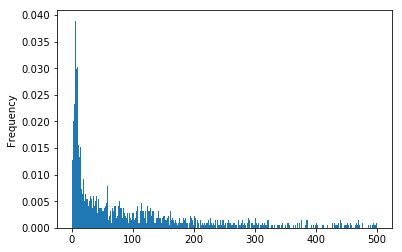

In [101]:
# examines word count of profiles
# IMPORTANT NOTE: 'request' package has error in which it cannot find end p tag </p>, thus 
# leading to description duplicates. Until this error is addressed, an abritrary cutoff is used.
profile_wc = [len(row.split()) for row in df_active['profile']]

pd.Series(profile_wc).plot.hist(normed=True, bins=np.arange(1, 500, 1))

plt.show()

The right tail is much longer than depicted, with ~3% of profiles exceeding our 500 word cut off. However, it would appear the majority of profiles fall well under 100-200 words.

What about what they say, if they do say something? Let's see what are the top 10 words commonly used. These are the words most likely to be used at least once in a profile description. And of course, this is excluding stop words, such as "the", "is", or "are".

In [132]:
# extracts mostly used common words
profile_wf = [set(row.lower().translate(str.maketrans('', '', string.punctuation)).split()) 
              for row in df_active.loc[hasprofile, 'profile']]
profile_wf = [item for sublist in profile_wf for item in sublist]
profile_wf = pd.Series(profile_wf).value_counts()

In [105]:
stop_word_list.append('im')
stop_word_list.append('dont')
print((profile_wf.loc[[row not in stop_word_list 
                        for row in profile_wf.index.values]][:10]/sum(hasprofile)).to_string())

like       0.315661
love       0.286297
one        0.250816
stories    0.241436
know       0.234095
writing    0.223491
write      0.216558
time       0.213703
name       0.207586
read       0.197390


Likes and dislikes, reading and writing. Very standard introduction words for a community like fanfiction.

The word "name" also made the list. We calculated and estimated it to be in ~21% of profiles that have something written. This prompts the question of what other information we might parse out. We looked into "gender"/"sex" and estimated ~6%. As for "age"/"old", also ~20%

In [115]:
name_count = (profile_wf['name'])/sum(hasprofile)
gender_count = (profile_wf['gender']+profile_wf['sex'])/sum(hasprofile)
age_count = (profile_wf['age']+profile_wf['old'])/sum(hasprofile)

In [134]:
profile_text = [row.lower().translate(str.maketrans('', '', string.punctuation)) 
              for row in df_active.loc[hasprofile, 'profile']]

In [ ]:
allgrams = []
for row in profile_text:
    token = nltk.word_tokenize(row)
    usergrams = set([row for row in ngrams(token,2)])
    allgrams.append([list(allgrams) for item in x])

/home/lily-tian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


## Gender

Now this is where things get tricky. So we've discovered that ~25% of users written something in their profiles. For those users, we want to figure out 1) if they have disclosed their gender, 2) get the machine to recognize what that gender is. For this exercise, we will only examine users who have disclosed in English.

We start with the most basic approach, which is to search for certain gender-related words that might be potential identifiers, then count how many profiles have those words.

In [37]:
female = ['female', 'girl', 'woman', 'daughter', 'mother', 'sister']
male = ['male', 'boy', 'man', 'son', 'father', 'brother']
other = ['agender', 'queer', 'nonbinary', 'transgender', 'trans', 'bigender', 'intergender']

In [130]:
gender_index = [m+'-'+n for m,n in zip(female, male)]
gender = pd.DataFrame(list(map(list, zip(profile_wf[female]/sum(hasprofile), 
                                         profile_wf[male]/sum(hasprofile)))), 
                      columns = ['female', 'male'])
gender = gender.set_index(pd.Series(gender_index))

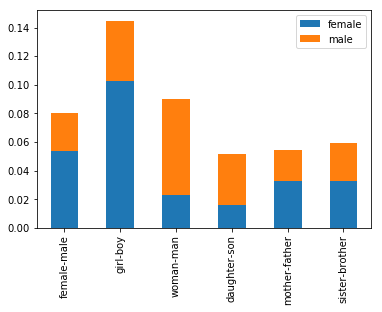

In [131]:
gender.plot.bar(stacked=True)

plt.ylabel('')
plt.show()

It should be noted that third-gender and non-binary words were also tested but yielded too little observations for analysis. As such, we will for now only focus on the female and male genders.

The words "female" and "male", we presume, are most likely to be used in the context of gender self-identification. This yields a rough 2:1 ratio, favoring female. However, we decided to also to do a check against other terminologies, which paints a much more mixed picture.

The problem with the next two pairs "girl"/"boy" and "woman"/"man" is that they may refer to third parties (eg. "I once met a girl who...). However, when those two columns are added together, there does not seem to be any evidence of a gender bias. The final three pairs are even more likely to refer to third parties, and are only there for comparison purposes only.

On a slight digression, the distribution of the word choices is interesting: "girl" is much more widely used than "woman" whereas "man" is more widely used than "boy".

The next approach that we want to try is a classification attempt. That is, identify what a profile is -- female or male -- based off their language.

## Favorites and follows

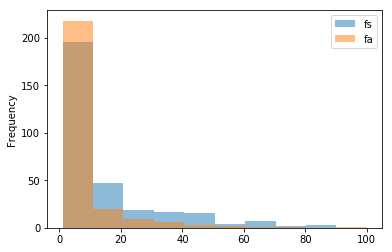

In [7]:
# examines distribution of favorited
fav = df_profile.loc[df_profile.status != 'inactive', ['fs', 'fa']]
fav.plot.hist(alpha = 0.5, range = [1, 100])

plt.show()

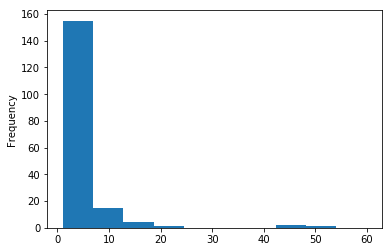

In [6]:
# examines distribution of stories written
st = df_profile.loc[df_profile.status != 'inactive', 'st']
st.plot.hist(range = [1, 60])

plt.show()

# Regression Analysis

In this section, we will try to predict the number of stories an (active) user would write based off the number of years have they been on the site, the number of authors/stories they have favorited, and whether or not they are in a community.

In [8]:
# creates copy of only active users
df_active = df_profile.loc[df_profile.status != 'inactive', ].copy()

# creates age variable
df_active['age'] = 17 - pd.to_numeric(df_active['join_year'])
df_active.loc[df_active.age < 0, 'age'] = df_active.loc[df_active.age < 0, 'age'] + 100
df_active = df_active[['st', 'fa', 'fs', 'cc', 'age']]

# turns cc into binary
df_active.loc[df_active['cc'] > 0, 'cc'] = 1

## Multicollinearity

In [9]:
# displays correlation matrix
df_active.corr()

,st,fa,fs,cc,age
st,1.000000,0.089321,0.142494,0.052937,0.170821
fa,0.089321,1.000000,0.706184,0.017645,0.007866
fs,0.142494,0.706184,1.000000,0.118110,0.011833
cc,0.052937,0.017645,0.118110,1.000000,0.113621
age,0.170821,0.007866,0.011833,0.113621,1.000000


In [10]:
# creates design_matrix 
X = df_active
X['intercept'] = 1

# displays variance inflation factor
vif_results = pd.DataFrame()
vif_results['VIF Factor'] = [vif(X.values, i) for i in range(X.shape[1])]
vif_results['features'] = X.columns
vif_results

,VIF Factor,features
0,1.051990,st
1,2.013037,fa
2,2.064973,fs
3,1.036716,cc
4,1.042636,age
5,2.824849,intercept


Results indicate there is some correlation between two of the independent variables: 'fa' and 'fs', implying one of them may not be necessary in the model.

## Nonlinearity

We know from earlier distributions that some of the variables are heavily right-skewed. We created some scatter plots to confirm that the assumption of linearity holds.

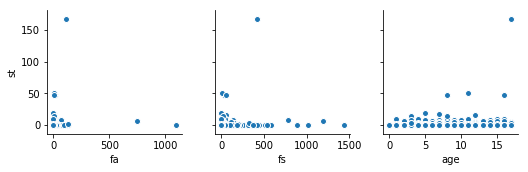

In [11]:
sns.pairplot(data=df_active, y_vars=['st'], x_vars=['fa', 'fs', 'age'])

plt.show()

The data is clustered around the zeros. Let's try a log transformation.

In [12]:
# takes log transformation
df_active['st'] = np.log(df_active['st']+1)
df_active['fa'] = np.log(df_active['fa']+1)
df_active['fs'] = np.log(df_active['fs']+1)

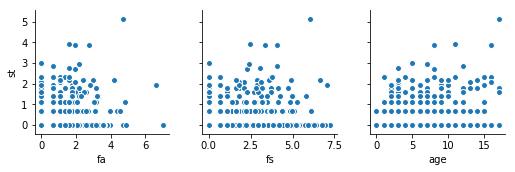

In [13]:
sns.pairplot(data=df_active, y_vars=['st'], x_vars=['fa', 'fs', 'age'])

plt.show()

## Regression Model

In [14]:
# runs OLS regression
formula = 'st ~ fa + fs + cc + age'
reg = smf.ols(data=df_active, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     61.31
Date:                Mon, 07 Aug 2017   Prob (F-statistic):           2.70e-46
Time:                        13:07:36   Log-Likelihood:                -757.62
No. Observations:                 992   AIC:                             1525.
Df Residuals:                     987   BIC:                             1550.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0338      0.029     -1.171      0.2

The log transformations helped increase the fit from and R-squared of ~0.05 to ~0.20.

From these results, we can see that:

* A 1% change in number of authors favorited is associated with a ~15% change in the number of stories written.
* A 1% change in number of stories favorited is associated with a ~4% change in the number of stories written.
* Being in a community is associated with a ~0.7 increase in the number of stories written.
* One more year on the site is associated with a ~3% change in the number of stories written.

We noted earlier that 'fa' and 'fs' had a correlation of ~0.7. As such, we reran the regression without 'fa' first, then again without 'fs'. The model without 'fs' yielded a better fit (R-squared), as well as AIC and BIC.

In [15]:
# runs OLS regression
formula = 'st ~ fa + cc + age'
reg = smf.ols(data=df_active, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     79.67
Date:                Mon, 07 Aug 2017   Prob (F-statistic):           3.69e-46
Time:                        13:07:37   Log-Likelihood:                -760.24
No. Observations:                 992   AIC:                             1528.
Df Residuals:                     988   BIC:                             1548.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0169      0.028     -0.605      0.5

Without 'fs', we lost some information but not much:

* A 1% change in number of authors favorited is associated with a ~20% change in the number of stories written.
* Being in a community is associated with a ~0.7 increase in the number of stories written.
* One more year on the site is associated with a ~3% change in the number of stories written.

All these results seem to confirm a basic intuition that the more active an user reads (as measured by favoriting authors and stories), the likely it is that user will write more stories. Being longer on the site and being part of a community is also correlated to publications.

To get a sense of the actual magnitude of these effects, let's attempt some plots:

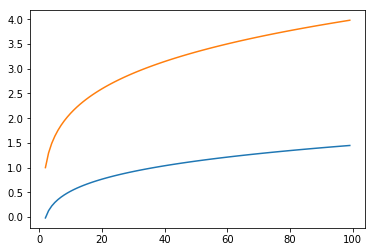

In [16]:
def graph(formula, x_range):  
    y = np.array(x_range)
    x = formula(y)
    plt.plot(y,x)  

graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1)))-1), 
      range(2,100,1))
graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1))+reg.params[2])-1), 
      range(2,100,1))

plt.show() 

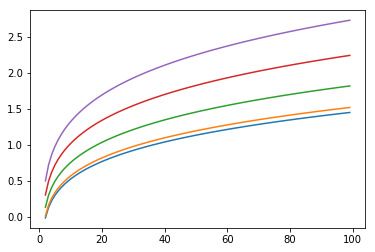

In [17]:
ages = [0, 1, 5, 10, 15]
for age in ages:
    graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1))+reg.params[3]*age)-1), 
          range(2,100,1))

plt.show() 